## Importing Libraries

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.datasets as dsets
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, Subtract, Lambda
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
import keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import os
from PIL import Image
from tensorflow.keras.layers import *
from tensorflow.keras import models , optimizers , losses ,activations , callbacks
from utils.face_mtcnn import *

## Checking MTCNN

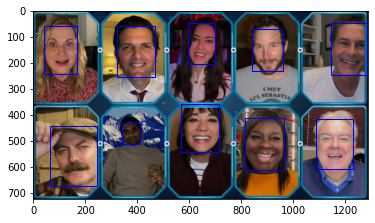

In [3]:
faces = detect_Faces('pnr.jpg')
draw_Boxes('pnr.jpg',faces)

25 265 1094 1334
39 273 277 511
390 630 769 1009
423 517 328 422
338 558 531 751
397 625 1044 1272
419 695 18 294
38 258 0 216
53 247 804 998
32 220 553 741


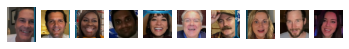

In [4]:
extract_Faces_Save('pnr.jpg',faces)

## Data Processing

### Extracting Faces

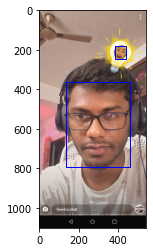

316 838 36 558
172 254 369 451


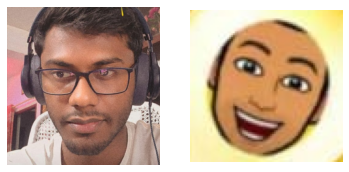

In [15]:
faces = detect_Faces('9.jpeg')
draw_Boxes('9.jpeg',faces)
extract_Faces_Save('9.jpeg',faces, True,'utils\\images\\')

In [17]:
dimen = 128

dir_path = 'utils\\images' #input( 'Enter images directory path : ')
out_path = 'utils\\processed_data' #input( 'Enter images output path : ')

sub_dir_list = os.listdir( dir_path )
images = list()
labels = list()
for i in range( len( sub_dir_list ) ):
	label = i
	image_names = os.listdir( os.path.join(dir_path , sub_dir_list[i]) )
	for image_path in image_names:
		path = os.path.join(dir_path , sub_dir_list[i] , image_path )
		try :
			image = Image.open(path)
			resize_image = image.resize((dimen, dimen))
			array_ = list()
			for x in range(dimen):
				sub_array = list()
				for y in range(dimen):
					sub_array.append(resize_image.load()[x, y])
				array_.append(sub_array)
			image_data = np.array(array_)
			image = np.array(np.reshape(image_data, (dimen, dimen, 3))) / 255
			images.append(image)
			labels.append(label)
		except:
			print( 'WARNING : File {} could not be processed.'.format( path ) )

images = np.array( images )

samples_1 = list()
samples_2 = list()
labels = list()
for i in range( 8 ) :
	for j in range( 8 ) :
		samples_1.append( images[i] )
		samples_2.append( images[j] )
		if i < 4 :
			if j < 4 :
				labels.append( 1 )
			else:
				labels.append( 0 )
		else :
			if j >= 4 :
				labels.append( 1 )
			else:
				labels.append( 0 )

X1 = np.array( samples_1  )
X2 = np.array( samples_2 )
Y = np.array( labels )

np.save( '{}/x1.npy'.format( out_path ), X1 )
np.save( '{}/x2.npy'.format( out_path ), X2 )
np.save( '{}/y.npy'.format( out_path ) , Y )

## Training the Model

In [18]:
X1 = np.load( 'utils\\processed_data\\x1.npy')
X2 = np.load( 'utils\\processed_data\\x2.npy')
Y = np.load( 'utils\\processed_data\\y.npy')
print( X1.shape )


X1 = X1.reshape( ( X1.shape[0]  , dimen**2 * 3  ) ).astype( np.float32 )
X2 = X2.reshape( ( X2.shape[0]  , dimen**2 * 3  ) ).astype( np.float32 )

print( X1.shape )
print( X2 )
print( Y )

(64, 128, 128, 3)
(64, 49152)
[[0.56078434 0.5372549  0.5529412  ... 0.09803922 0.07450981 0.12156863]
 [0.36862746 0.48235294 0.36078432 ... 0.09411765 0.11372549 0.2784314 ]
 [0.44313726 0.3764706  0.3254902  ... 0.4745098  0.48235294 0.5411765 ]
 ...
 [1.         1.         0.99215686 ... 0.5764706  0.6117647  0.67058825]
 [0.7254902  0.61960787 0.5764706  ... 0.35686275 0.3254902  0.34117648]
 [0.4392157  0.41568628 0.3764706  ... 0.5764706  0.6627451  0.7254902 ]]
[1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1
 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1]


In [29]:
input_shape = ( (128**2) * 3 , )
convolution_shape = (128 , 128, 3)
seq_conv_model = [
    Reshape( input_shape=input_shape , target_shape=convolution_shape),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
	tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
	tf.keras.layers.MaxPooling2D(2,2),
	tf.keras.layers.Flatten(),
	tf.keras.layers.Dense(128, activation='sigmoid')
]
seq_model = tf.keras.Sequential( seq_conv_model )

input_x1 = Input( shape=input_shape )
input_x2 = Input( shape=input_shape ) 
output_x1 = seq_model( input_x1 )
output_x2 = seq_model( input_x2 )

distance_euclid = Lambda( lambda tensors : K.abs( tensors[0] - tensors[1] ))( [output_x1 , output_x2] )
outputs = Dense( 1 , activation='sigmoid') ( distance_euclid )
model = models.Model( [ input_x1 , input_x2 ] , outputs )

model.compile( loss=losses.binary_crossentropy , optimizer=optimizers.Adam(lr=0.0001), metrics = ['accuracy'])

hyperparameters = {
    'batch_size' : 8 ,
    'epochs' : 15 ,
    'callbacks' : None ,
    'val_data' : None
}

initial_time = time.time()
history = model.fit( [ X1, X2 ]  , Y ,
	batch_size=hyperparameters[ 'batch_size' ] ,
	epochs=hyperparameters[ 'epochs' ] ,
	callbacks=hyperparameters[ 'callbacks'],
	validation_data=hyperparameters[ 'val_data' ]
)
final_time = time.time()
eta = ( final_time - initial_time )
time_unit = 'seconds'
if eta >= 60 :
    eta = eta / 60
    time_unit = 'minutes'
model.summary( )
print( 'Elapsed time acquired for {} epoch(s) -> {} {}'.format( hyperparameters[ 'epochs' ] , eta , time_unit ) )
model.save('utils\\models\\siamese_model.h5')

Epoch 1/15
8/8 [==============================] - 0s 18ms/step - loss: 0.6933 - accuracy: 0.5469
Epoch 2/15
8/8 [==============================] - 0s 17ms/step - loss: 0.6720 - accuracy: 0.8125
Epoch 3/15
8/8 [==============================] - 0s 16ms/step - loss: 0.6317 - accuracy: 0.7969
Epoch 4/15
8/8 [==============================] - 0s 16ms/step - loss: 0.5848 - accuracy: 0.9062
Epoch 5/15
8/8 [==============================] - 0s 16ms/step - loss: 0.5292 - accuracy: 1.0000
Epoch 6/15
8/8 [==============================] - 0s 17ms/step - loss: 0.4610 - accuracy: 0.9531
Epoch 7/15
8/8 [==============================] - 0s 16ms/step - loss: 0.3768 - accuracy: 1.0000
Epoch 8/15
8/8 [==============================] - 0s 17ms/step - loss: 0.2863 - accuracy: 1.0000
Epoch 9/15
8/8 [==============================] - 0s 17ms/step - loss: 0.2216 - accuracy: 1.0000
Epoch 10/15
8/8 [==============================] - 0s 17ms/step - loss: 0.1718 - accuracy: 1.0000
Epoch 11/15
8/8 [============

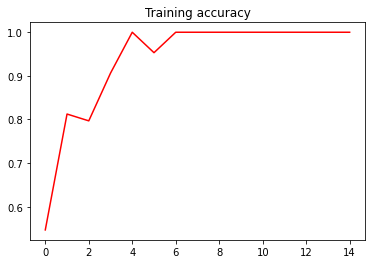

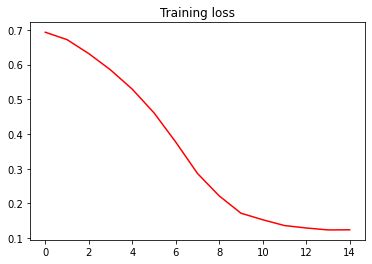

In [30]:
acc = history.history['accuracy']# Your Code Here
loss = history.history['loss']# Your Code Here

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training loss')

plt.show()

In [26]:
model = models.load_model('utils\\models\\siamese_model.h5')

## Predicting on Test Images

In [31]:
def prepare_images_from_dir(dir_path , flatten=True ) :
	dimen = 128
	images = list()
	images_names = os.listdir( dir_path )
	for imageName in images_names :
		image = Image.open(dir_path + imageName)
		resize_image = image.resize((dimen,dimen))
		array = list()
		for x in range(dimen):
			sub_array = list()
			for y in range(dimen):
				sub_array.append(resize_image.load()[x, y])
			array.append(sub_array)
		image_data = np.array(array)
		image = np.array(np.reshape(image_data,(dimen, dimen, 3)))
		images.append(image)
	if flatten :
		images = np.array(images)
		return images.reshape( ( images.shape[0]  , dimen**2 * 3  ) ).astype( np.float32 )
	else:
		return np.array(images)

In [32]:
custom_images = prepare_images_from_dir( 'utils\\custom_images\\')
class_1_images = prepare_images_from_dir( 'utils\\images\\p1\\')
class_2_images = prepare_images_from_dir( 'utils\\images\\p2\\')

scores = list()
labels = list()
for image in custom_images:
    label = list()
    score = list()
    for sample in class_1_images :
        image , sample = image.reshape( ( 1 , -1 ) ) , sample.reshape((1 , -1 ) )
        score.append( model.predict( [ image , sample ])[0] )
        label.append( 0 )
    for sample in class_2_images :
        image , sample = image.reshape( ( 1 , -1 ) ) , sample.reshape((1 , -1 ) )
        score.append( model.predict( [ image , sample ])[0] )
        label.append( 1 )
    labels.append( label )
    scores.append( score )

scores = np.array( scores )
labels = np.array( labels )

for i in range( custom_images.shape[0] ) :
    index = np.argmax( scores[i] )
    label_ = labels[i][index]
    print( 'IMAGE {} is {} with confidence of {}'.format( i+1  , label_ , scores[i][index][0] ) )


IMAGE 1 is 1 with confidence of 0.793336033821106
IMAGE 2 is 0 with confidence of 0.9442132711410522
IMAGE 3 is 0 with confidence of 0.9885770082473755
IMAGE 4 is 1 with confidence of 0.9636440277099609
